In [13]:
!pip install catboost
!pip install scikit-learn
!pip install xgboost
!pip install seaborn

# Import Packages and CSV

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

In [15]:
df = pd.read_csv('train.csv')
df.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23


### Data Cleaning
##### Check Null Values

In [16]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Artist Reputation 11.53846 % missing values
Height 5.76923 % missing values
Width 8.98462 % missing values
Weight 9.03077 % missing values
Material 11.75385 % missing values
Transport 21.41538 % missing values
Remote Location 11.86154 % missing values


### Checking duplicated values

In [17]:
df.duplicated().sum()

0

### Seperating Features

In [18]:
target_feature = 'Cost'

# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
numeric_features.remove(target_feature)
non_numeric_features = [feature for feature in df.columns if df[feature].dtype == 'O']

print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} Non Numeric features : {}'.format(len(non_numeric_features), non_numeric_features))

We have 6 numerical features : ['Artist Reputation', 'Height', 'Width', 'Weight', 'Price Of Sculpture', 'Base Shipping Price']

We have 13 Non Numeric features : ['Customer Id', 'Artist Name', 'Material', 'International', 'Express Shipment', 'Installation Included', 'Transport', 'Fragile', 'Customer Information', 'Remote Location', 'Scheduled Date', 'Delivery Date', 'Customer Location']


In [40]:
df1 = df.copy()
for i in numeric_features:
    df1[i].fillna(df1[i].median(), inplace=True)

### Multicollinearity Check
##### Variance Inflation Factor (VIF)

In [41]:
!pip install statsmodels
import statsmodels.api as sm

for i in range(0, len(numeric_features)):
    x = df1.loc[:, df1.columns == numeric_features[i]]
    y = df1.Cost
    model = sm.OLS(x,y)
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            numeric_features[i], vif)
        )

Variance Inflation Factor of Artist Reputation column is 1.01 

Variance Inflation Factor of Height column is 1.01 

Variance Inflation Factor of Width column is 1.02 

Variance Inflation Factor of Weight column is 1.2 

Variance Inflation Factor of Price Of Sculpture column is 1.3 

Variance Inflation Factor of Base Shipping Price column is 1.01 



#### Note: All the columns has VIF around 1, so there is not severe multicollinearity

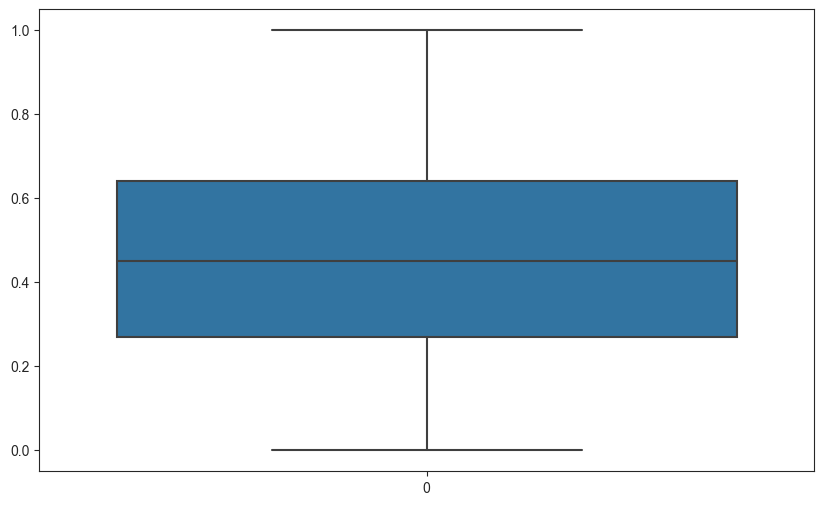

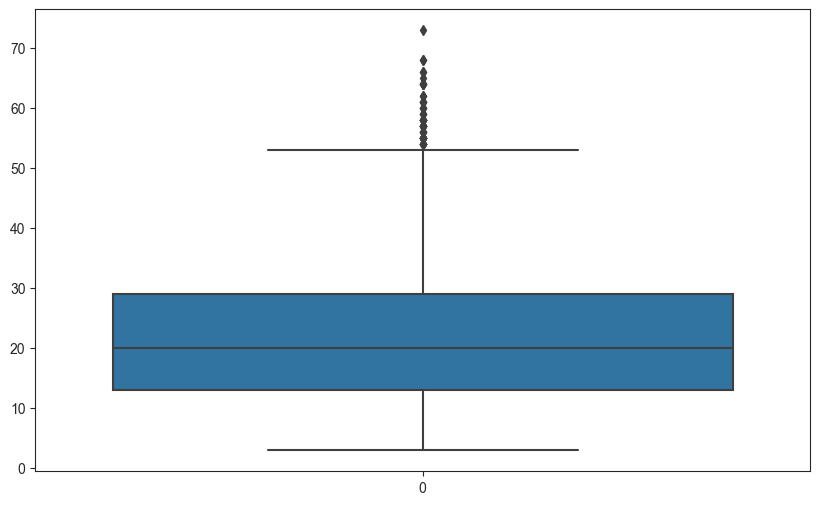

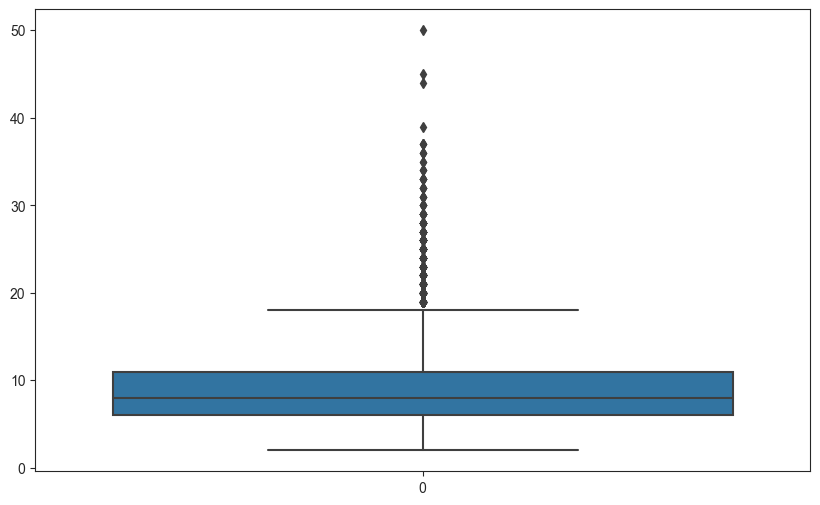

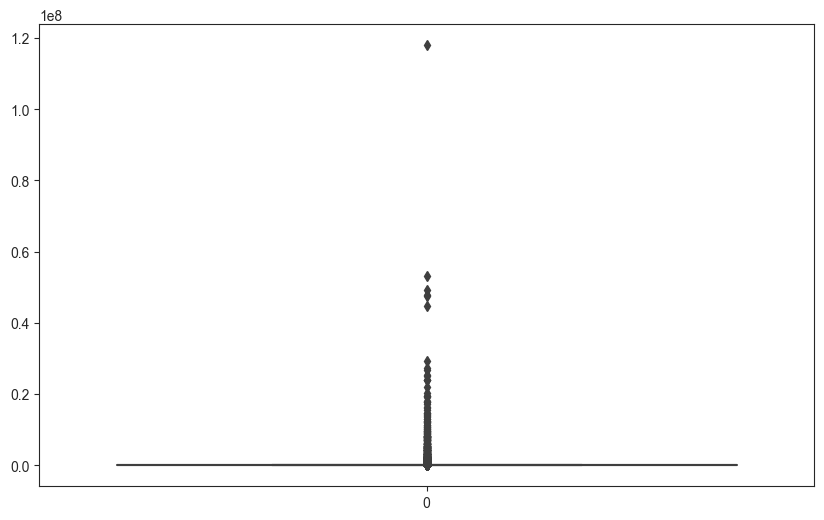

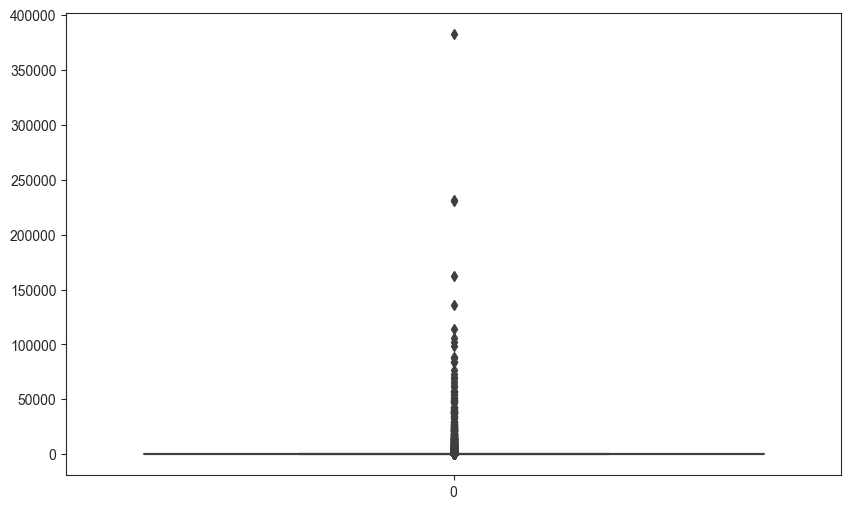

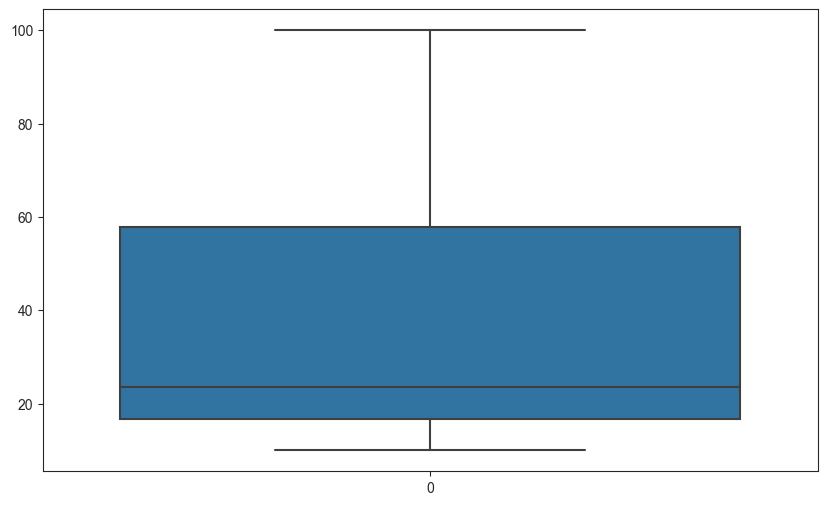

In [42]:
for i in numeric_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df1[i])

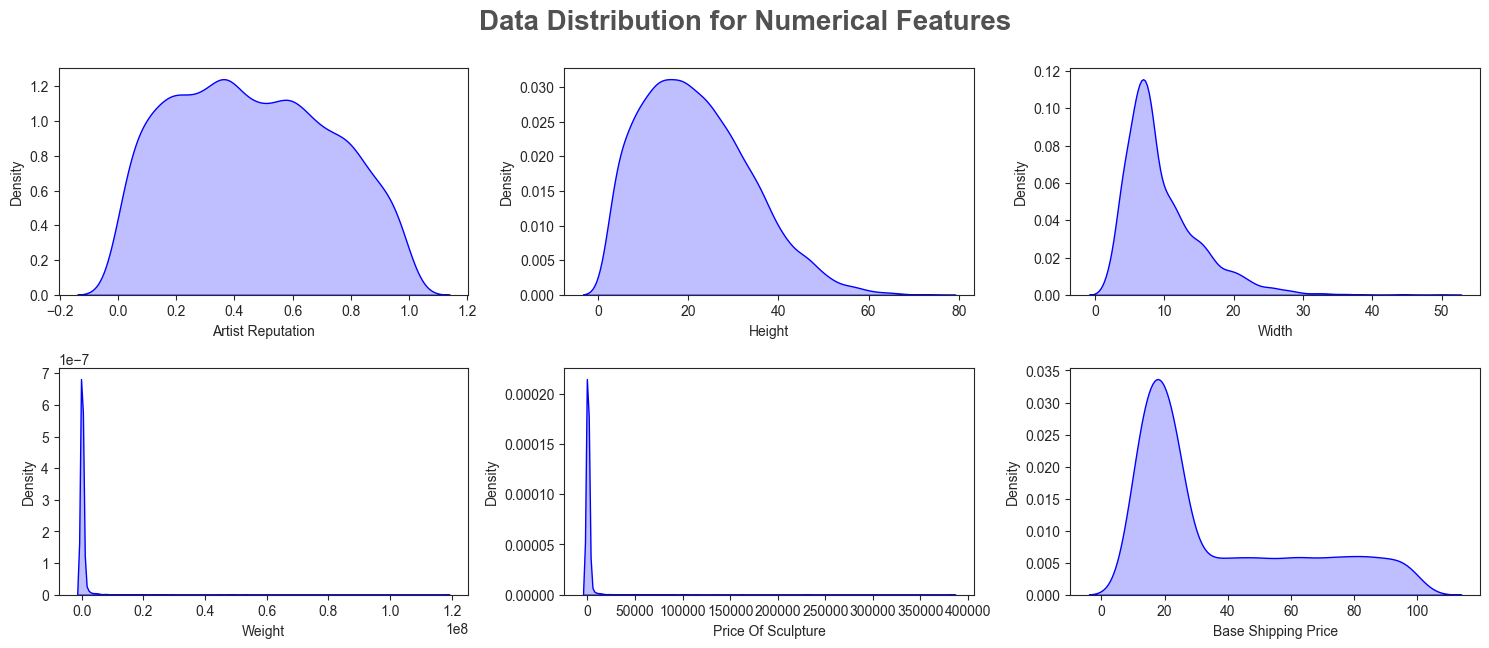

In [43]:
plt.figure(figsize=(15, 15))
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=df[numeric_features[i]],shade=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

In [44]:
df[numeric_features].skew()

Artist Reputation       0.141363
Height                  0.594041
Width                   1.546702
Weight                 21.556174
Price Of Sculpture     22.206823
Base Shipping Price     0.918102
dtype: float64

##### Checking the power transformer on outlier columns

In [45]:
outlier_feature = ['Price Of Sculpture', 'Weight']

In [46]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(standardize=False)

outlier_data = df1[outlier_feature]

In [47]:
df1[outlier_feature] = pt.fit_transform(df1[outlier_feature])

In [48]:
df_outlier = pd.DataFrame(outlier_data, columns=outlier_feature)

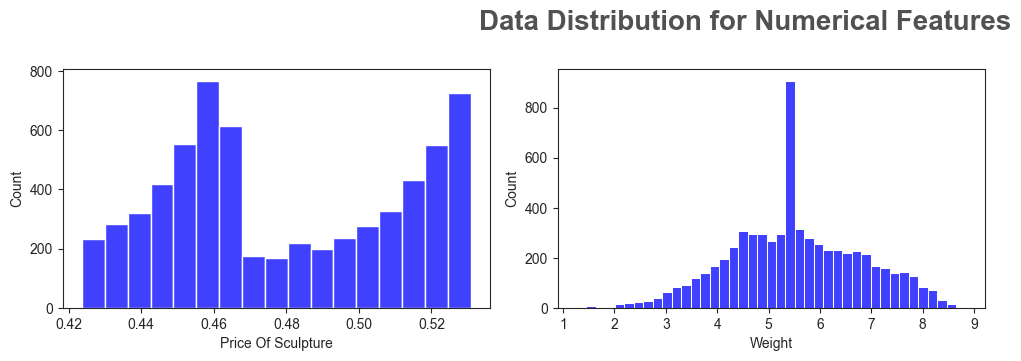

In [31]:
plt.figure(figsize=(15, 15))
plt.suptitle('Data Distribution for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(outlier_feature)):
    plt.subplot(5, 3, i+1)
    sns.histplot(x=df1[outlier_feature[i]], color='b')
    plt.xlabel(outlier_feature[i])
    plt.tight_layout()

In [49]:
df1[outlier_feature].skew()

Price Of Sculpture    0.478648
Weight                0.027309
dtype: float64

### Insights

#### Power transformer does a better job at overcoming skewness and handling outliers
### Why outliers?

##### -Data Entry error : Human error.
##### -Measurement error: Instrument error.
##### -Natural error: it will be Real life data.
##### -Intentional error: People give wrong inputs
### Impact of Outliers ?

##### -Ouliers can very high impact on few Machine learning models.
##### -Can Cause bias in the output.

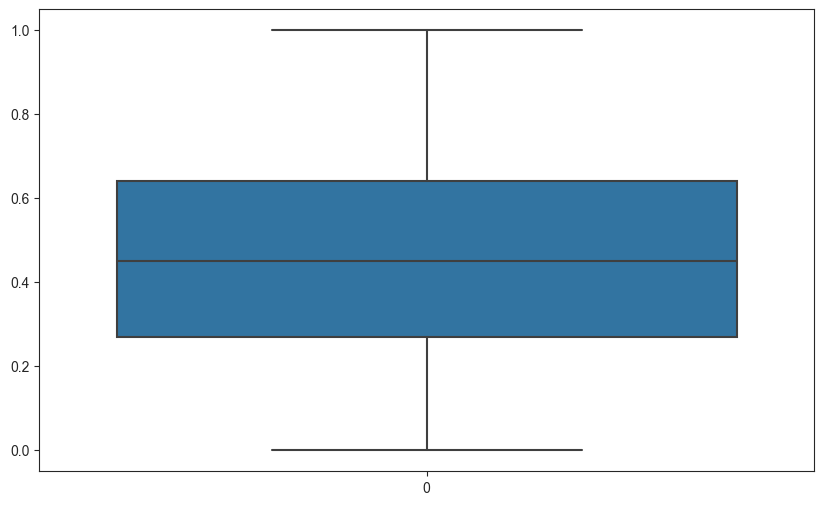

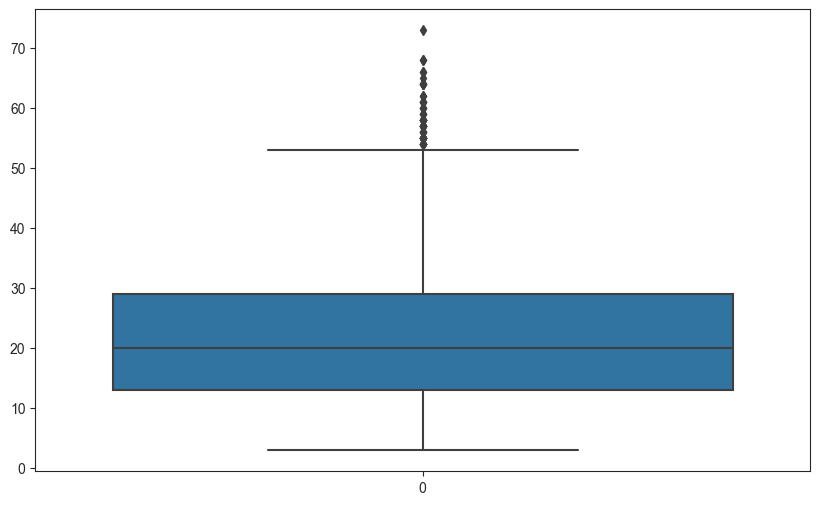

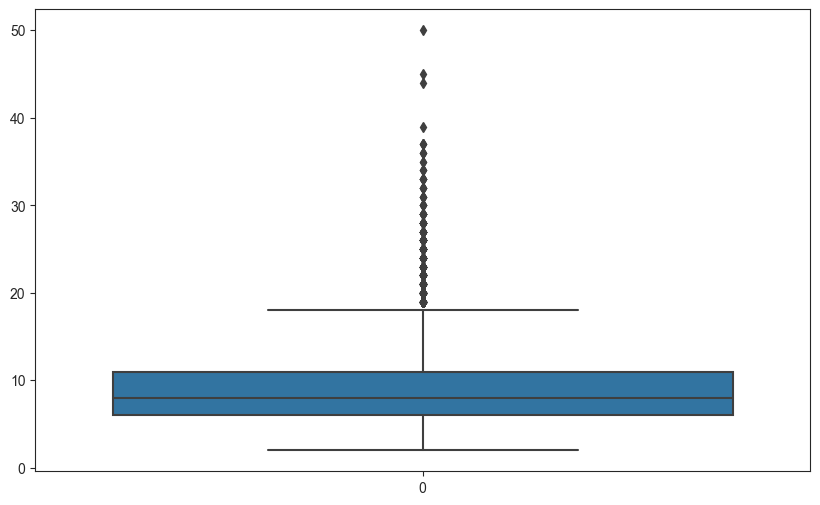

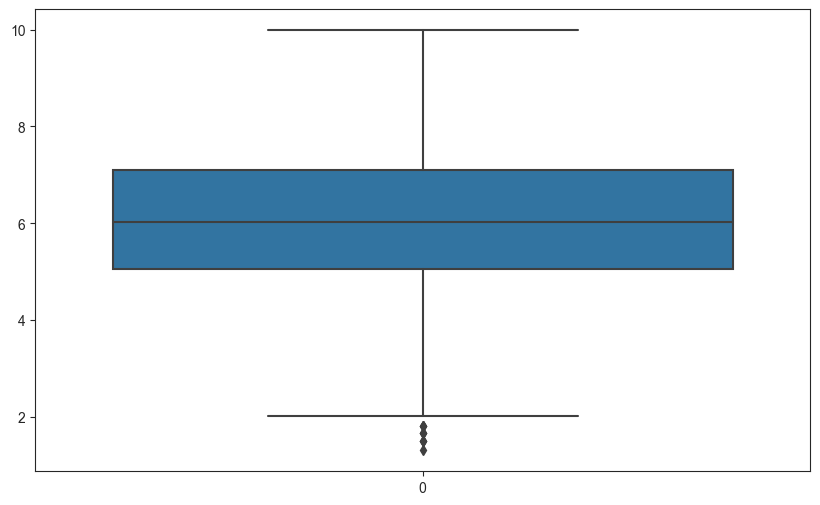

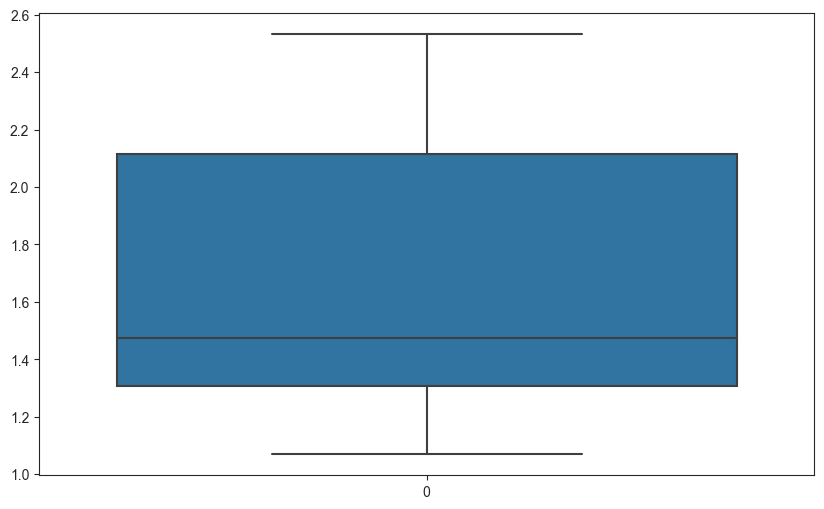

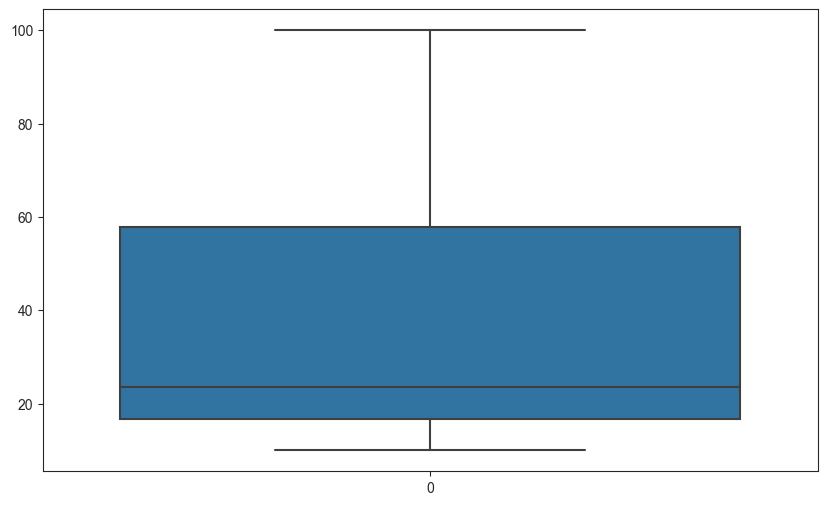

In [50]:
for i in numeric_features:
    plt.figure(figsize=(10,6))
    sns.set_style('ticks')
    ax = sns.boxplot(df1[i])

#### Removing outliers from Target Column

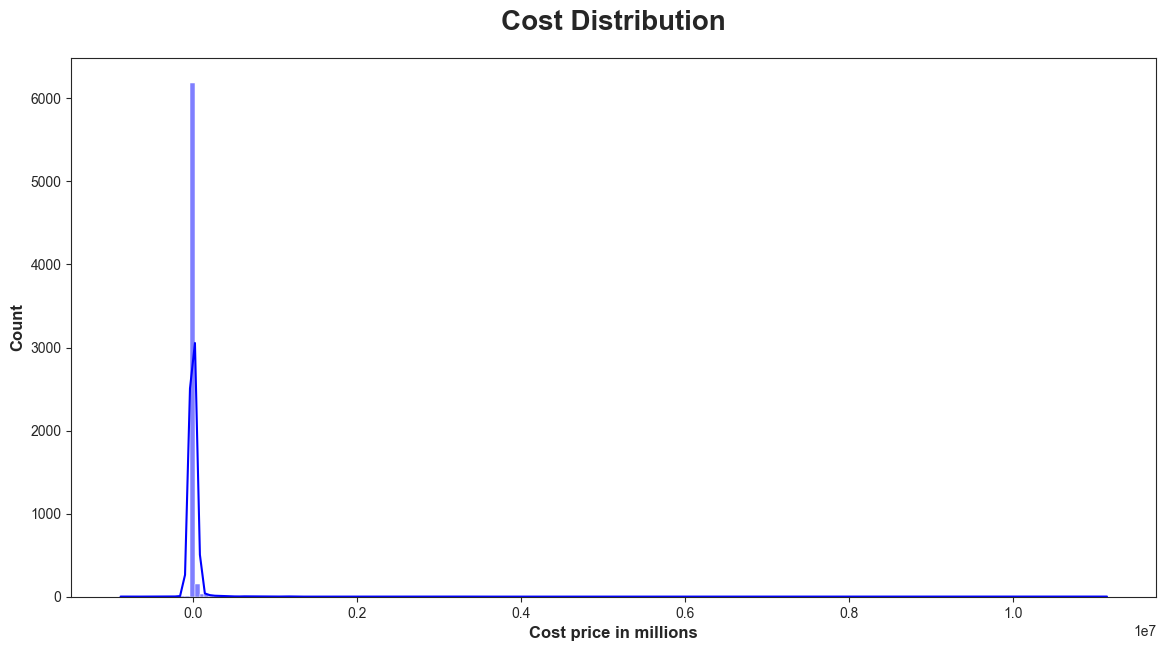

In [51]:
plt.subplots(figsize=(14,7))
sns.histplot(df['Cost'], bins=200, kde=True, color = 'b')
plt.title("Cost Distribution", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=12)
plt.xlabel("Cost price in millions", weight="bold", fontsize=12)
plt.show()

In [52]:
df1['Cost'] = np.log1p(df1['Cost'])

(array([1973., 1985.,  954.,  461.,  223.,  127.,   64.,   32.,   16.,
           6.]),
 array([ 4.46671239,  5.64267721,  6.81864203,  7.99460685,  9.17057167,
        10.34653649, 11.5225013 , 12.69846612, 13.87443094, 15.05039576,
        16.22636058]),
 <BarContainer object of 10 artists>)

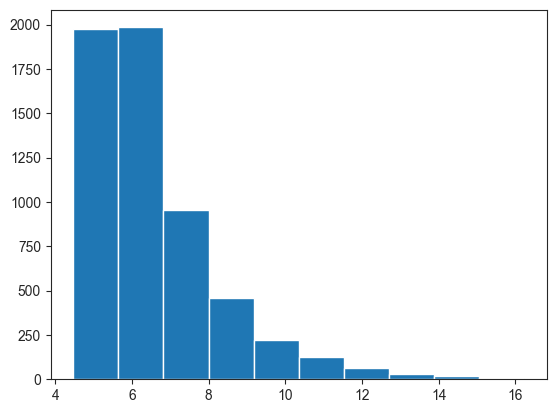

In [53]:
plt.hist(df1['Cost'])

### Feature Creation for Date Columns

In [54]:
# Convert object datatype to datetime
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'])
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])

In [55]:
df['Month'] = pd.to_datetime(df['Scheduled Date']).dt.month
df['Year'] = pd.to_datetime(df['Scheduled Date']).dt.year

numeric_features.append('Month')
numeric_features.append('Year')

### Drop Unneccessary column

In [56]:
to_drop_columns = ['Customer Id', 'Artist Name', 'Customer Location', 'Scheduled Date', 'Delivery Date']

In [57]:
df.drop(columns=to_drop_columns, inplace=True)

## Model Building

In [84]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

## Split X and y

In [85]:
X = df.drop(columns = ['Cost'], axis=1)
y = np.abs(df['Cost'])

In [86]:
y = np.log1p(y)

## Train Test Split
#### -The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

#### -It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Encoding and Scaling
##### Selecting Numerical and categorical features for feature scaling

In [88]:
numeric_features = [x for x in numeric_features if x not in outlier_feature]
categorical_features = [x for x in non_numeric_features if x not in to_drop_columns]

(numeric_features), (categorical_features), (outlier_feature)

(['Artist Reputation',
  'Height',
  'Width',
  'Base Shipping Price',
  'Month',
  'Year'],
 ['Material',
  'International',
  'Express Shipment',
  'Installation Included',
  'Transport',
  'Fragile',
  'Customer Information',
  'Remote Location'],
 ['Price Of Sculpture', 'Weight'])

In [89]:
numeric_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder()),
]
)

outliers_features_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', PowerTransformer(standardize=True))
])

preprocessor = ColumnTransformer(
    [
        ("Numeric Pipeline",numeric_features_pipeline, numeric_features),
        ("Categorical Features Pipeline",categorical_features_pipeline, categorical_features),
        ("Outliers Features Pipeline", outliers_features_pipeline, outlier_feature)
]
)

In [90]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [95]:
# functions which takes true and predicted values to calculate metrics
def evaluate_reg(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [100]:
# Define your models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor()
}


# function which can evaluate models and return a report 
def evaluate_models(X_train, X_test, y_train, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''    
    models_list = []
    r2_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate Train and Test dataset
        model_train_mae , model_train_rmse, model_train_r2 = evaluate_reg(y_train, y_train_pred)

        model_test_mae , model_test_rmse, model_test_r2 = evaluate_reg(y_test, y_test_pred)


        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
        print("- R2 Score: {:.4f}".format(model_train_r2))

        print('----------------------------------')

        print('Model performance for Test set')
        print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
        print("- R2 Score: {:.4f}".format(model_test_r2))
        r2_list.append(model_test_r2)

        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, r2_list)), columns=['Model Name', 'r2_score']).sort_values(by=['r2_score'], ascending=False)
        
    return report

In [101]:
base_report = evaluate_models(X_train, X_test, y_train, y_test, models)

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.7357
- Mean Absolute Error: 0.4971
- R2 Score: 0.8014
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.6966
- Mean Absolute Error: 0.4841
- R2 Score: 0.8218


Ridge Regression
Model performance for Training set
- Root Mean Squared Error: 0.7357
- Mean Absolute Error: 0.4970
- R2 Score: 0.8014
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.6965
- Mean Absolute Error: 0.4840
- R2 Score: 0.8218


Lasso Regression
Model performance for Training set
- Root Mean Squared Error: 1.3807
- Mean Absolute Error: 0.9717
- R2 Score: 0.3006
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.3753
- Mean Absolute Error: 0.9873
- R2 Score: 0.3052


SVR
Model performance for Training set
- Root Mean Squared Error: 0.4694
- Mean Absolute Error: 0.2297
- R2 Score: 0.9192
-------------------

199:	learn: 0.2845076	total: 559ms	remaining: 2.23s
200:	learn: 0.2841612	total: 561ms	remaining: 2.23s
201:	learn: 0.2836677	total: 563ms	remaining: 2.22s
202:	learn: 0.2832029	total: 565ms	remaining: 2.22s
203:	learn: 0.2822344	total: 567ms	remaining: 2.21s
204:	learn: 0.2817154	total: 569ms	remaining: 2.21s
205:	learn: 0.2812912	total: 571ms	remaining: 2.2s
206:	learn: 0.2805056	total: 574ms	remaining: 2.2s
207:	learn: 0.2800027	total: 577ms	remaining: 2.19s
208:	learn: 0.2793303	total: 579ms	remaining: 2.19s
209:	learn: 0.2789450	total: 581ms	remaining: 2.18s
210:	learn: 0.2786029	total: 583ms	remaining: 2.18s
211:	learn: 0.2781032	total: 585ms	remaining: 2.17s
212:	learn: 0.2776761	total: 587ms	remaining: 2.17s
213:	learn: 0.2771204	total: 589ms	remaining: 2.16s
214:	learn: 0.2768130	total: 591ms	remaining: 2.16s
215:	learn: 0.2763984	total: 593ms	remaining: 2.15s
216:	learn: 0.2759351	total: 596ms	remaining: 2.15s
217:	learn: 0.2756109	total: 598ms	remaining: 2.14s
218:	learn: 0.

387:	learn: 0.2246676	total: 951ms	remaining: 1.5s
388:	learn: 0.2245306	total: 954ms	remaining: 1.5s
389:	learn: 0.2242512	total: 956ms	remaining: 1.49s
390:	learn: 0.2241325	total: 958ms	remaining: 1.49s
391:	learn: 0.2238081	total: 960ms	remaining: 1.49s
392:	learn: 0.2234516	total: 962ms	remaining: 1.49s
393:	learn: 0.2232927	total: 964ms	remaining: 1.48s
394:	learn: 0.2230786	total: 966ms	remaining: 1.48s
395:	learn: 0.2229432	total: 968ms	remaining: 1.48s
396:	learn: 0.2227901	total: 970ms	remaining: 1.47s
397:	learn: 0.2226473	total: 972ms	remaining: 1.47s
398:	learn: 0.2224758	total: 974ms	remaining: 1.47s
399:	learn: 0.2222527	total: 977ms	remaining: 1.46s
400:	learn: 0.2219940	total: 979ms	remaining: 1.46s
401:	learn: 0.2218647	total: 981ms	remaining: 1.46s
402:	learn: 0.2217387	total: 983ms	remaining: 1.46s
403:	learn: 0.2216178	total: 985ms	remaining: 1.45s
404:	learn: 0.2214075	total: 987ms	remaining: 1.45s
405:	learn: 0.2213002	total: 989ms	remaining: 1.45s
406:	learn: 0.

560:	learn: 0.1976214	total: 1.34s	remaining: 1.05s
561:	learn: 0.1974615	total: 1.34s	remaining: 1.04s
562:	learn: 0.1973922	total: 1.34s	remaining: 1.04s
563:	learn: 0.1972475	total: 1.34s	remaining: 1.04s
564:	learn: 0.1971386	total: 1.35s	remaining: 1.04s
565:	learn: 0.1970405	total: 1.35s	remaining: 1.03s
566:	learn: 0.1968990	total: 1.35s	remaining: 1.03s
567:	learn: 0.1967357	total: 1.35s	remaining: 1.03s
568:	learn: 0.1966350	total: 1.36s	remaining: 1.03s
569:	learn: 0.1965214	total: 1.36s	remaining: 1.02s
570:	learn: 0.1964662	total: 1.36s	remaining: 1.02s
571:	learn: 0.1963394	total: 1.36s	remaining: 1.02s
572:	learn: 0.1962789	total: 1.36s	remaining: 1.02s
573:	learn: 0.1961288	total: 1.37s	remaining: 1.01s
574:	learn: 0.1960217	total: 1.37s	remaining: 1.01s
575:	learn: 0.1959227	total: 1.37s	remaining: 1.01s
576:	learn: 0.1958596	total: 1.37s	remaining: 1.01s
577:	learn: 0.1957347	total: 1.38s	remaining: 1s
578:	learn: 0.1956210	total: 1.38s	remaining: 1s
579:	learn: 0.1955

746:	learn: 0.1785695	total: 1.73s	remaining: 587ms
747:	learn: 0.1785177	total: 1.74s	remaining: 585ms
748:	learn: 0.1784613	total: 1.74s	remaining: 582ms
749:	learn: 0.1783917	total: 1.74s	remaining: 580ms
750:	learn: 0.1783550	total: 1.74s	remaining: 577ms
751:	learn: 0.1782202	total: 1.74s	remaining: 575ms
752:	learn: 0.1781604	total: 1.75s	remaining: 573ms
753:	learn: 0.1781047	total: 1.75s	remaining: 570ms
754:	learn: 0.1780478	total: 1.75s	remaining: 568ms
755:	learn: 0.1779771	total: 1.75s	remaining: 565ms
756:	learn: 0.1779137	total: 1.75s	remaining: 563ms
757:	learn: 0.1778996	total: 1.75s	remaining: 561ms
758:	learn: 0.1778164	total: 1.76s	remaining: 558ms
759:	learn: 0.1776872	total: 1.76s	remaining: 556ms
760:	learn: 0.1776286	total: 1.76s	remaining: 554ms
761:	learn: 0.1775788	total: 1.76s	remaining: 551ms
762:	learn: 0.1775008	total: 1.77s	remaining: 549ms
763:	learn: 0.1774689	total: 1.77s	remaining: 546ms
764:	learn: 0.1773559	total: 1.77s	remaining: 544ms
765:	learn: 

925:	learn: 0.1645987	total: 2.13s	remaining: 170ms
926:	learn: 0.1645026	total: 2.13s	remaining: 168ms
927:	learn: 0.1644268	total: 2.13s	remaining: 166ms
928:	learn: 0.1643167	total: 2.14s	remaining: 163ms
929:	learn: 0.1642585	total: 2.14s	remaining: 161ms
930:	learn: 0.1642370	total: 2.14s	remaining: 159ms
931:	learn: 0.1641800	total: 2.14s	remaining: 156ms
932:	learn: 0.1641432	total: 2.15s	remaining: 154ms
933:	learn: 0.1640817	total: 2.15s	remaining: 152ms
934:	learn: 0.1640038	total: 2.15s	remaining: 149ms
935:	learn: 0.1639498	total: 2.15s	remaining: 147ms
936:	learn: 0.1638306	total: 2.15s	remaining: 145ms
937:	learn: 0.1637831	total: 2.16s	remaining: 143ms
938:	learn: 0.1636981	total: 2.16s	remaining: 140ms
939:	learn: 0.1635865	total: 2.16s	remaining: 138ms
940:	learn: 0.1635679	total: 2.16s	remaining: 136ms
941:	learn: 0.1634999	total: 2.17s	remaining: 133ms
942:	learn: 0.1634032	total: 2.17s	remaining: 131ms
943:	learn: 0.1633579	total: 2.17s	remaining: 129ms
944:	learn: 

In [102]:
# Initialize models required for model
models = {
    "Linear Regression": LinearRegression(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False, max_depth=5),
    "AdaBoost Regressor": AdaBoostRegressor(), 
    "SVR": SVR()
}

In [103]:
base_report

,Model Name,r2_score
7,CatBoost,0.971866
6,XGBoost,0.958326
4,Random Forest,0.956021
3,SVR,0.913033
5,AdaBoost,0.861697
1,Ridge Regression,0.821791
0,Linear Regression,0.821773
2,Lasso Regression,0.305173


## Hyperparameter Tuning

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# Initialize parameter grids for each model
rf_params = {
    "max_depth": [5, 8, 15, None],
    "max_features": [5, 7, "auto", 8],
    "min_samples_split": [2, 8, 15, 20],
    "n_estimators": [100, 200, 500, 1000]
}

xgboost_params = {
    "learning_rate": [0.1, 0.01],
    "max_depth": [5, 8, 12, 20, 30],
    "n_estimators": [100, 200, 300],
    "colsample_bytree": [0.5, 0.8, 1.0, 0.3, 0.4]
}

catboost_params = {
    "learning_rate": [0.1, 0.01, 0.6, 0.5],
    "max_depth": [4, 5, 6, 8, 12]
}


In [118]:
# Define the models for hyperparameter tuning
randomcv_models = [
    ("RF", RandomForestRegressor(), rf_params),
    ('XGBoost', XGBRegressor(), xgboost_params),
    ('CatBoost', CatBoostRegressor(verbose=False), catboost_params)
]

In [122]:
# Perform RandomizedSearchCV for each model
model_param = {}
for name, model, params in randomcv_models:
    print(f"Running RandomizedSearchCV for {name}...")
    random = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                n_iter=5,  # Adjust as needed
                                cv=3,
                                verbose=2,
                                n_jobs=1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

# Print the best parameters found for each model
for model_name, best_params in model_param.items():
    print(f"---------------- Best Params for {model_name} -------------------")
    print(best_params)

Running RandomizedSearchCV for RF...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=8, max_features=5, min_samples_split=8, n_estimators=500; total time=   2.2s
[CV] END max_depth=8, max_features=5, min_samples_split=8, n_estimators=500; total time=   1.6s
[CV] END max_depth=8, max_features=5, min_samples_split=8, n_estimators=500; total time=   1.7s
[CV] END max_depth=None, max_features=7, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, max_features=7, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, max_features=7, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, max_features=5, min_samples_split=8, n_estimators=1000; total time=   5.3s
[CV] END max_depth=None, max_features=5, min_samples_split=8, n_estimators=1000; total time=   4.7s
[CV] END max_depth=None, max_features=5, min_samples_split=8, n_estimators=1000; total time=   4.8s
[CV] END max_depth

In [123]:
# reInitialize models with best parameters
models = {
    "Random Forest Regressor": RandomForestRegressor(**model_param['RF'], n_jobs=-1),
    "XGBRegressor": XGBRegressor(**model_param['XGBoost'], n_jobs=-1), 
     "CatBoosting Regressor": CatBoostRegressor(**model_param['CatBoost'],verbose=False)
}

In [124]:
retrained_report = evaluate_models(X_train, X_test, y_train, y_test, models)

Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1697
- Mean Absolute Error: 0.1082
- R2 Score: 0.9894
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3450
- Mean Absolute Error: 0.2028
- R2 Score: 0.9563


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 0.0005
- Mean Absolute Error: 0.0004
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3337
- Mean Absolute Error: 0.1800
- R2 Score: 0.9591


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1171
- Mean Absolute Error: 0.0775
- R2 Score: 0.9950
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.2803
- Mean Absolute Error: 0.1629
- R2 Score: 0.9711




In [125]:
retrained_report

,Model Name,r2_score
2,CatBoosting Regressor,0.971135
1,XGBRegressor,0.959092
0,Random Forest Regressor,0.956286


## Best Model is CATBoost Regressor with 97.11% Score